<a href="https://colab.research.google.com/github/Ensyllis/Notes-and-Projects/blob/main/Quant_Stochastic_Modeling_%5BGeometric_Brownian_Motion_Stochastic_Model_Jump_Diffusion%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


* Geometric Brownian Motion


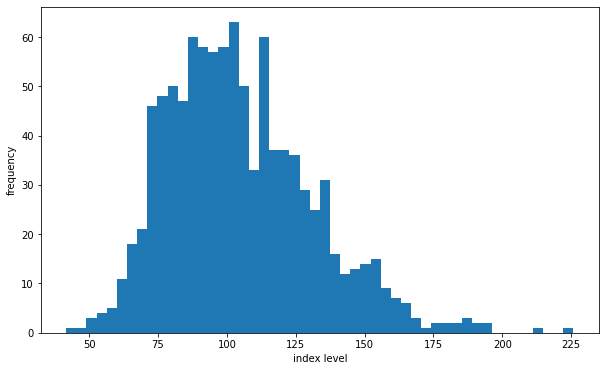

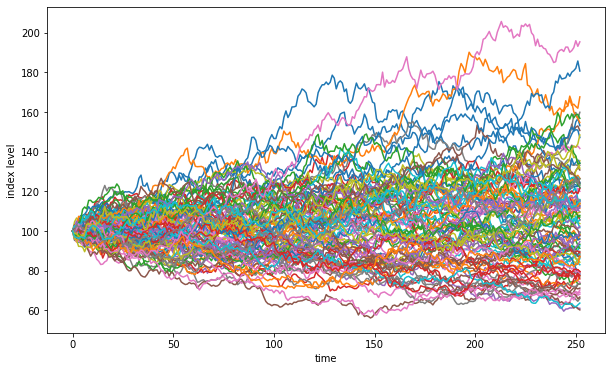

In [ ]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

# Geometric Brownian Motion (granual/steps)
S0 = 100 # starting price
r = 0.05 # short rate
sigma = 0.25 # vol
I = 1000 # simulations
M = 252 # steps per sim
T = 1
dt = T/M
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
            sigma * math.sqrt(dt) * npr.standard_normal(I))

plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency');

plt.figure(figsize=(10, 6))
plt.plot(S[:, :100], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level');

We now Generate Mean-Reverting Series
- Ie. If I eat at a McDonalds I usually hope a bad meal is followed by a more likely better meal

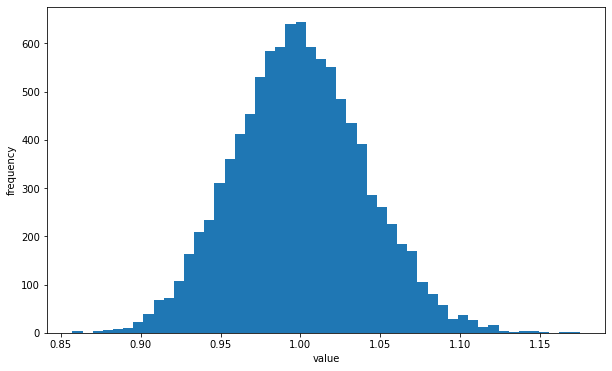

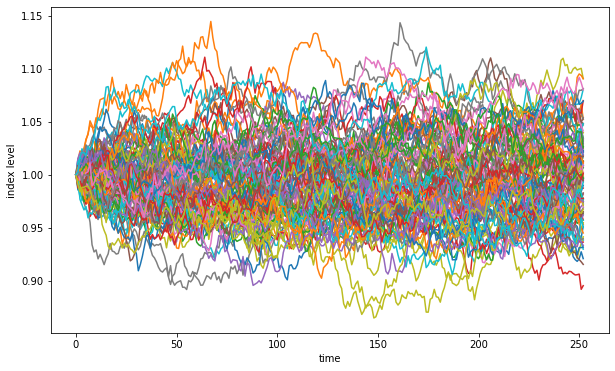

In [ ]:

# Square-Root Diffusion (mean-reverting process)-------------------------------
# widely used for short rates & volatility
x0 = 1.00 # starting value
kappa = 3.0 # mean-reversion paramater
theta = 1.00 # long term mean
sigma = 0.1
I = 10000
T = 1
M = 252
dt = T / M

def srd_euler():
    xh = np.zeros((M + 1, I))
    x = np.zeros_like(xh)
    xh[0] = x0
    x[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1] +
                 kappa * (theta - np.maximum(xh[t - 1], 0)) * dt +
                 sigma * np.sqrt(np.maximum(xh[t - 1], 0)) *
                 math.sqrt(dt) * npr.standard_normal(I))
    x = np.maximum(xh, 0)
    return x
x1 = srd_euler()

plt.figure(figsize=(10, 6))
plt.hist(x1[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency');

plt.figure(figsize=(10, 6))
plt.plot(x1[:, :100], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level');

Modeling with stochastic Process Probability

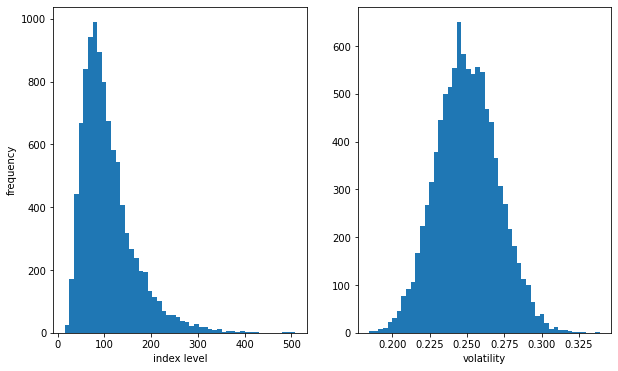

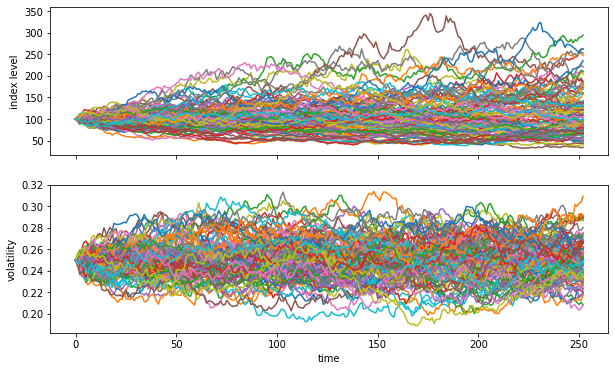

In [ ]:
# Stochastic Volatility--------------------------------------------------------
# <><><> the index is simulated using stochastic volatility <><><><><><><>
S0 = 100. # starting index price
r = 0.05 # short rate
v0 = 0.25 # initial volatility
kappa = 3.0 # same as square root diffusion (reversion factor)
theta = 0.25 # long term mean (volatility)
sigma = 0.1 # volatility of SRD model?
rho = 0.6 # correlation b/w vol and the index
T = 1.0

corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)
cho_mat

M = 252
I = 10000
dt = T / M

ran_num = npr.standard_normal((2, M + 1, I))

v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)

v[0] = v0 
vh[0] = v0

for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] +
             kappa * (theta - np.maximum(vh[t - 1], 0)) * dt +
             sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * 
             math.sqrt(dt) * ran[1])

v = np.maximum(vh, 0)

S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
                    np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility');

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(10, 6))
ax1.plot(S[:, :100], lw=1.5)
ax1.set_ylabel('index level')
ax2.plot(v[:, :100], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility');

In [ ]:
np.mean(S)

104.22506509205624

Merton Stochastic Jump Processes
- It uses the Poisson Process to Figure Out how large the jumps are

In [ ]:

# Jump-Diffusion---------------------------------------------------------------
# jumps/price shocks added to GBM model
S0 = 100. # initial price
r = 0.05 # short rate
sigma = 0.2 # vol
lamb = 0.75 # jump likelihood
mu = npr.normal(0,0.1) # jump amount
delta = 0.1 # variability in jump amount
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)

T = 1.0
M = 252
I = 10000
dt = T / M

S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb * dt, (M + 1, I)) # poission dist derived by lambda, dt
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt +
                       sigma * math.sqrt(dt) * sn1[t]) +
                       (np.exp(mu + delta * sn2[t]) - 1) *
                       poi[t])
    S[t] = np.maximum(S[t], 0)

plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency'); # bi-modal freq distr

plt.figure(figsize=(10, 6))
plt.plot(S[:, :100], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level');